<a href="https://colab.research.google.com/github/Rad-Monk/Code/blob/main/LP_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import tensorflow as tf
import PIL
import PIL.Image
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

`glob` is used to match path names in unix style

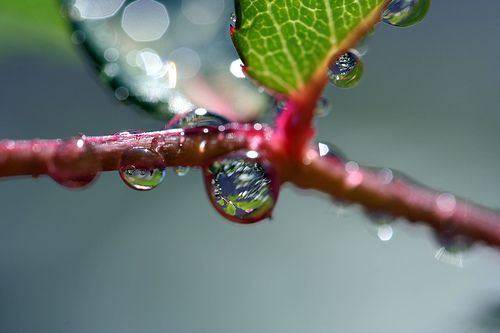

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

In [ ]:
batch_size = 32
image_height = 180
image_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed = 123,
    validation_split = .2,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    subset = 'training'
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed= 123,
    validation_split = .2,
    image_size = (image_height, image_width),
    batch_size = 32,
    subset = 'validation'
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

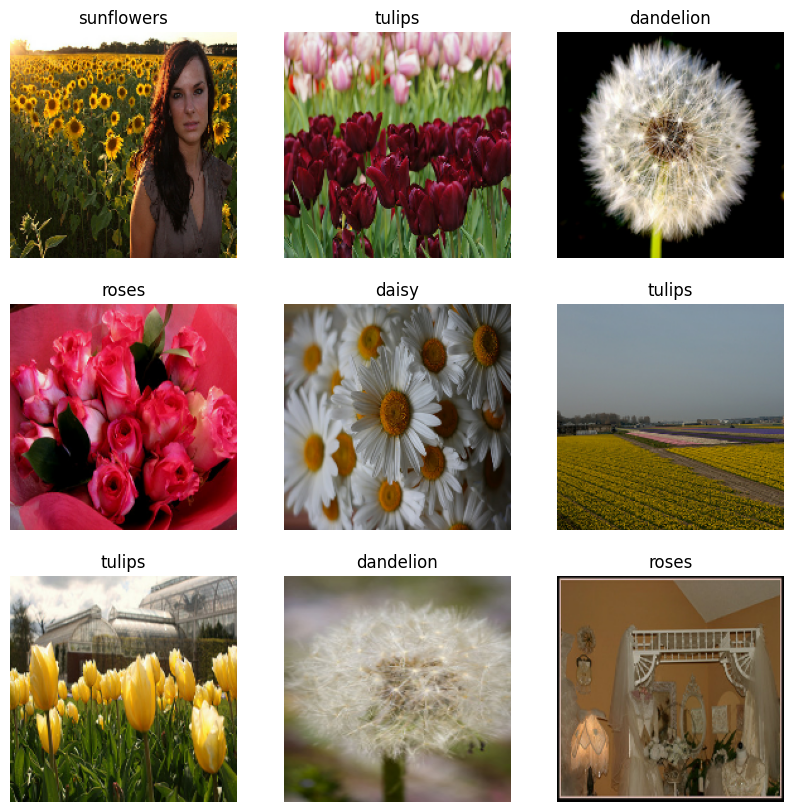

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10 , 10))
for images,labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")


In [ ]:
for images_batch, labels_batch in train_ds:
  print(images_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.23730373 0.92265797


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32,3, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(.0001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(32,3, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(.0001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(32,3, activation = 'relu',kernel_regularizer = tf.keras.regularizers.L2(.0001)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(len(class_names))]
)

In [ ]:
len(class_names)

5

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 6s 45ms/step - loss: 1.3495 - accuracy: 0.3995 - val_loss: 1.2195 - val_accuracy: 0.5300
Epoch 2/3
92/92 [==============================] - 4s 41ms/step - loss: 1.0845 - accuracy: 0.5688 - val_loss: 1.0947 - val_accuracy: 0.5845
Epoch 3/3
92/92 [==============================] - 4s 42ms/step - loss: 0.9769 - accuracy: 0.6124 - val_loss: 1.0138 - val_accuracy: 0.6213


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))

In [ ]:
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [ ]:
image_count

3670

In [ ]:
val_size = int(image_count * .2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_height, image_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print(image.shape)
  print(label.numpy())

(180, 180, 3)
3


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  ds = ds.batch(batch_size)

  return ds

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

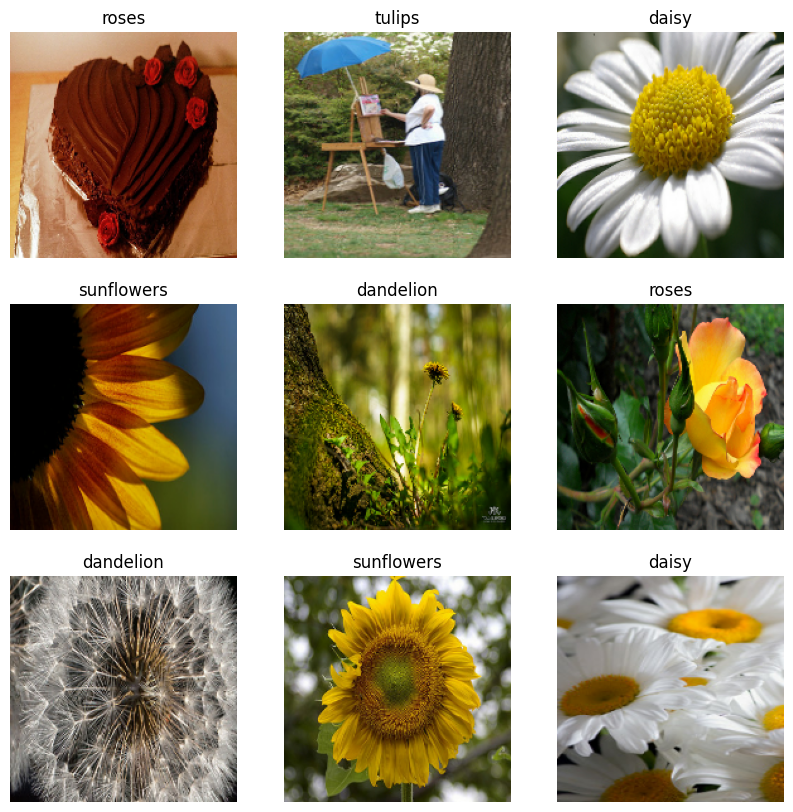

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
model.fit(
    train_ds,
    validation_data= val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 11s 86ms/step - loss: 0.8987 - accuracy: 0.6512 - val_loss: 0.8323 - val_accuracy: 0.6689
Epoch 2/3
92/92 [==============================] - 4s 45ms/step - loss: 0.7274 - accuracy: 0.7180 - val_loss: 0.8422 - val_accuracy: 0.6744
Epoch 3/3
92/92 [==============================] - 5s 51ms/step - loss: 0.5756 - accuracy: 0.7878 - val_loss: 0.8319 - val_accuracy: 0.6689


In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info = True,
    as_supervised = True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_class = metadata.features['label'].num_classes
num_class

5

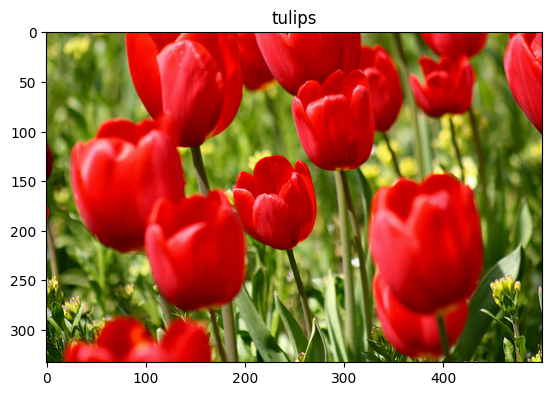

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)